In [1]:
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
from skbio.stats import composition
import numpy as np


def clr(counts_data,log= np.log):


    #TODO: check if count data

    # remove columns with all
    data= counts_data.loc[:,~(counts_data<=1).all()]

    #dataframe with replace zeros
    data= pd.DataFrame( composition.multiplicative_replacement(data),
                       columns=data.columns,
                       index= data.index
                      )

    data= log(data)
    data = (data.T-data.mean(1)).T

    return data



In [3]:
concat = pd.DataFrame()
for file in glob("metadata_sources/MetaPhlAn/2021*.tsv"):
    loaded_df = pd.read_csv(file, sep = '\t', index_col=0, low_memory=False).transpose()
    concat = pd.concat([concat,loaded_df], join = "outer")

In [4]:
list_of_species = []
other_list = []
for i in concat.columns:
    if i.startswith("k_"):
        list_of_species.append(i)
    else:
        other_list.append(i)
len(list_of_species)

2040

In [5]:
filled_df = concat.fillna(value=0)
for species in list_of_species:
    filled_df[species] = pd.to_numeric(filled_df[species])

In [6]:
healthy_samples = filled_df[filled_df['disease']=="healthy"]
temperatures = pd.DataFrame()
temperatures["country"] = healthy_samples.country.value_counts().index
temperatures["temperature"] = [14.9,11.8,13,25,13,10.7,5.8,6.3,17.4,26,15.3,-0.1,12.4,-0.6,3.8,29.6,6.4,27.75,26.55,12.7,24.25,19.4,26.35,-1.35,8.95,18.7,14.9,17,28.35,11.1,27.2,24.95,10.4,30.3,30.6,29.6,26.6,4.6]
healthy_with_temp = healthy_samples.merge(temperatures, on = "country")

In [7]:
healthy_with_temp = healthy_with_temp[healthy_with_temp['body_site']=="stool"]
adult_df = healthy_with_temp[healthy_with_temp["age_category"]=="adult"]
adult_non_west = adult_df[adult_df["non_westernized"]=="no"]

In [8]:
list_of_species_adult = []
for i in adult_non_west.columns:
    if i.startswith("k__"):
        list_of_species_adult.append(i)

In [9]:
only_species = pd.DataFrame()
for species in list_of_species_adult:
    only_species = pd.concat([only_species,adult_non_west[species]], axis =1)

In [10]:
clr_species = clr(only_species)

In [11]:
clr_transformed_with_temp = pd.concat([pd.DataFrame(clr_species),adult_non_west["temperature"]],axis =1).reset_index(drop=True)

Text(0.5, 1.0, 'Correlation between average temperatures (in C) and their MetaPhLan profiles.\nCountries are aggregated by taking mean abundance per species for all samples from that country.\nCorrelation between profiles is pearson')

<Figure size 2160x1800 with 0 Axes>

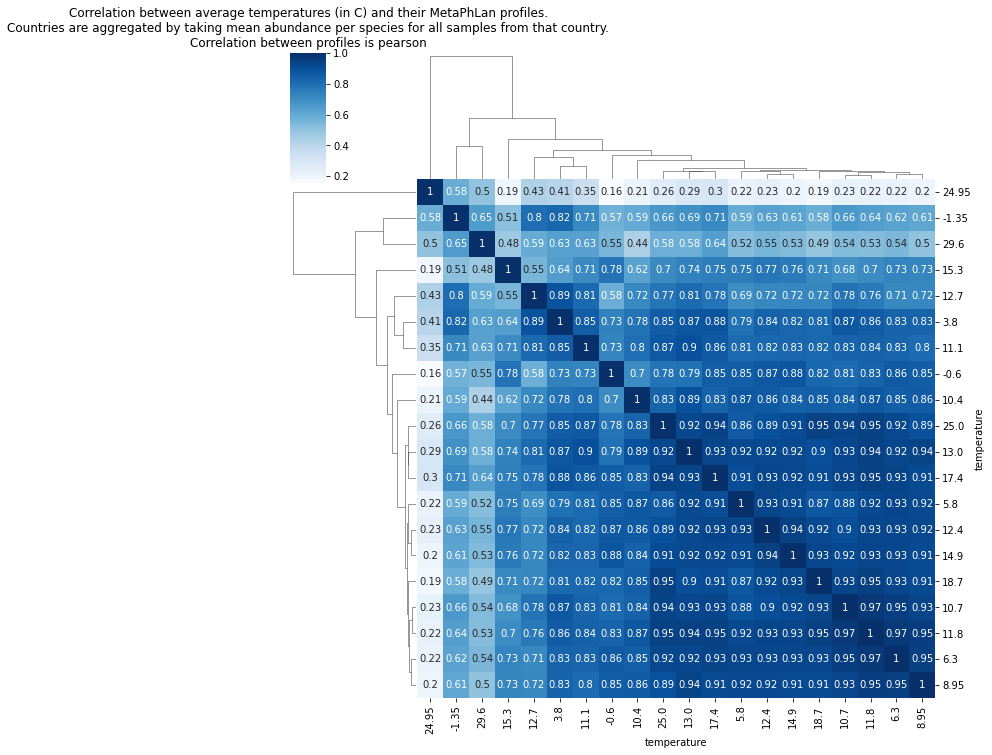

In [12]:
general_corr = clr_transformed_with_temp.groupby("temperature").median().transpose()
fig = plt.figure(figsize=(30,25))
heatmap = sns.clustermap(general_corr.corr(method='pearson'), annot = True, cmap="Blues")
plt.title("Correlation between average temperatures (in C) and their MetaPhLan profiles.\n"
          "Countries are aggregated by taking mean abundance per species for all samples from that country.\n"
          "Correlation between profiles is pearson")

Text(0.5, 1.0, 'Correlation between average temperatures (in C) and their MetaPhLan profiles, after dropping BGD (24.95C).\nCountries are aggregated by taking mean abundance per species for all samples from that country.\nCorrelation between profiles is spearman')

<Figure size 2160x1800 with 0 Axes>

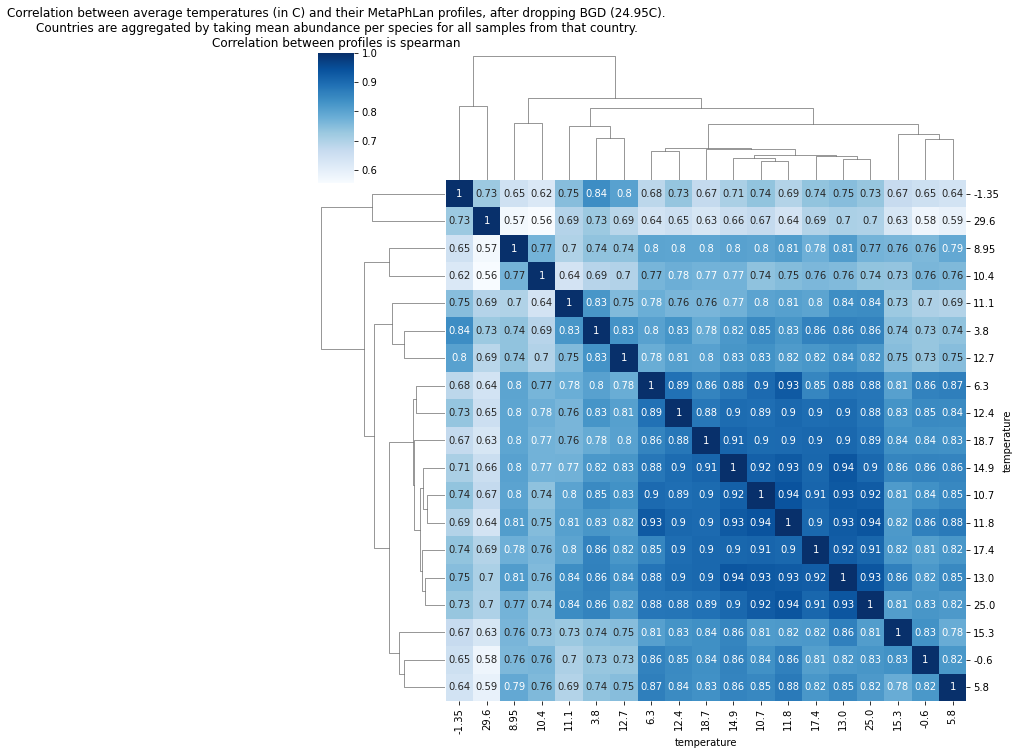

In [13]:
#Dropping country corresponding to 24.95C - something is different about it (outlier)
clr_transformed_with_temp = clr_transformed_with_temp[clr_transformed_with_temp["temperature"]!=24.95]
general_corr = clr_transformed_with_temp.groupby("temperature").median().transpose()
fig = plt.figure(figsize=(30,25))
heatmap = sns.clustermap(general_corr.corr(method='spearman'), annot = True, cmap="Blues")
plt.title("Correlation between average temperatures (in C) and their MetaPhLan profiles, after dropping BGD (24.95C).\n"
          "Countries are aggregated by taking mean abundance per species for all samples from that country.\n"
          "Correlation between profiles is spearman")

In [14]:
clr_species = []
for i in clr_transformed_with_temp.columns:
    if i.startswith("k__"):
        clr_species.append(i)

In [15]:
dataframe_per_species = pd.DataFrame()
counter = 0
for species in clr_species:
    dataframe_per_species = pd.concat([dataframe_per_species,pd.DataFrame(clr_transformed_with_temp.groupby("temperature").median()[species])], axis =1)
    counter += 1
    print(counter)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [16]:
dataframe_per_species = dataframe_per_species.reset_index()

In [17]:
for species in dataframe_per_species.columns:
    dataframe_per_species[species] = pd.to_numeric(dataframe_per_species[species])

For k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_fragilis: -0.5506848774787911 and p-value of 0.014549932570021467
For k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_unclassified|g__Intestinimonas|s__Intestinimonas_butyriciproducens: -0.47776520595199556 and p-value of 0.03856303161611379
For k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruthenibacterium|s__Ruthenibacterium_lactatiformans: -0.6077618252204062 and p-value of 0.005774024337663184
For k__Bacteria|p__Firmicutes|c__Firmicutes_unclassified|o__Firmicutes_unclassified|f__Firmicutes_unclassified|g__Firmicutes_unclassified|s__Firmicutes_bacterium_CAG_83: -0.488219570069467 and p-value of 0.033939621692379116
For k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_salyersiae: 0.5033724931775826 and p-value of 0.028015348314410205
For k__Bacteria|p__Bac

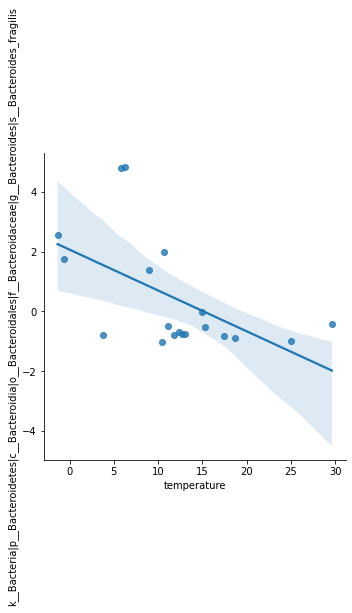

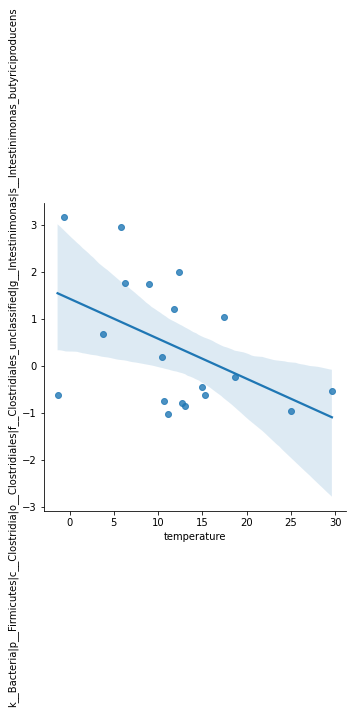

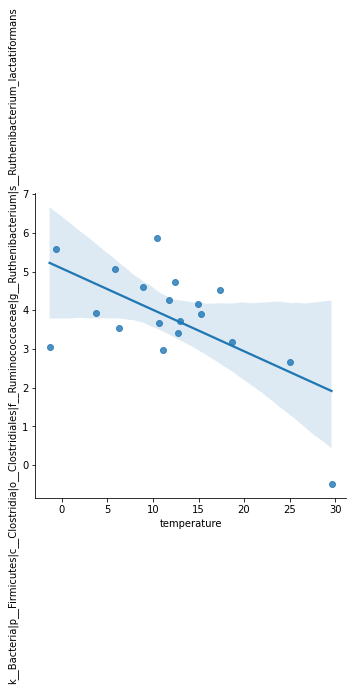

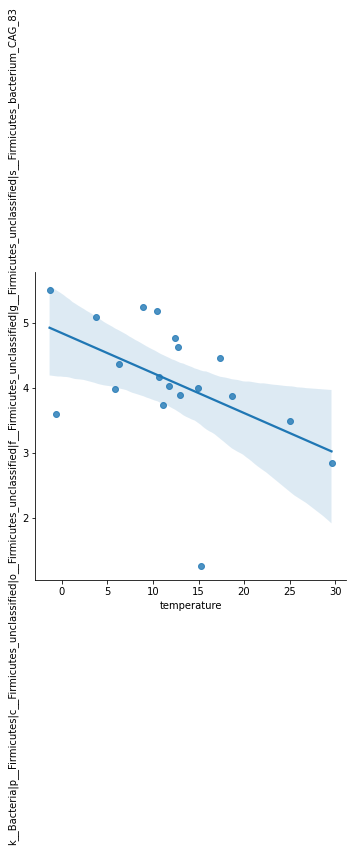

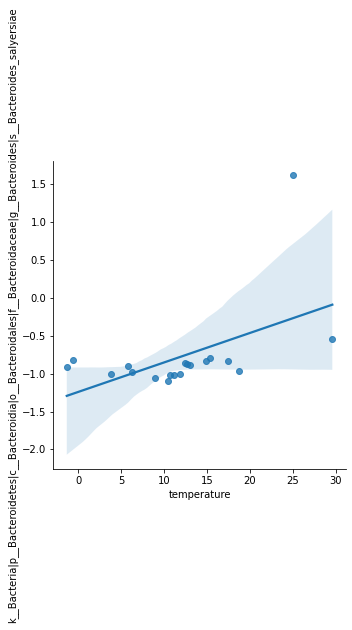

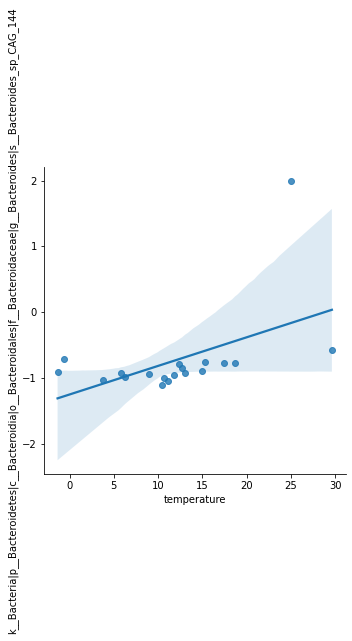

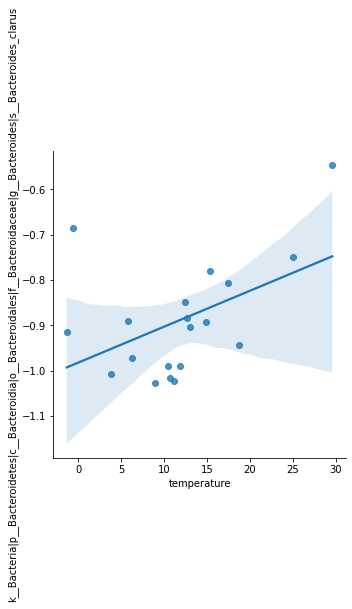

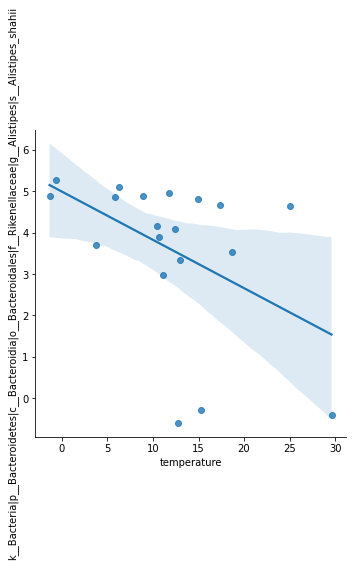

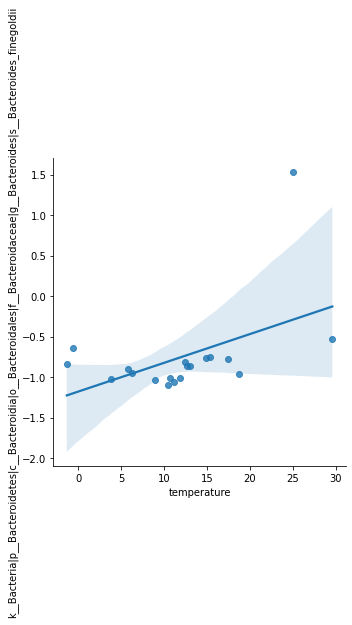

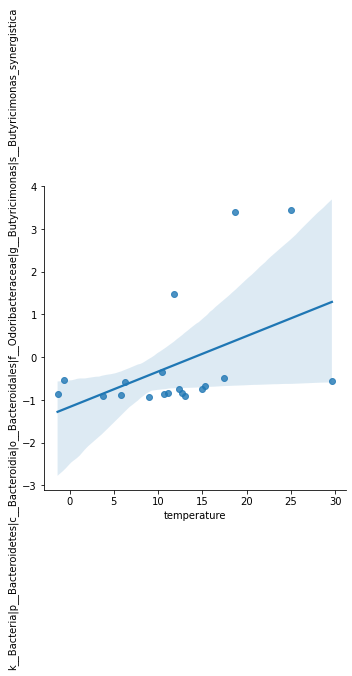

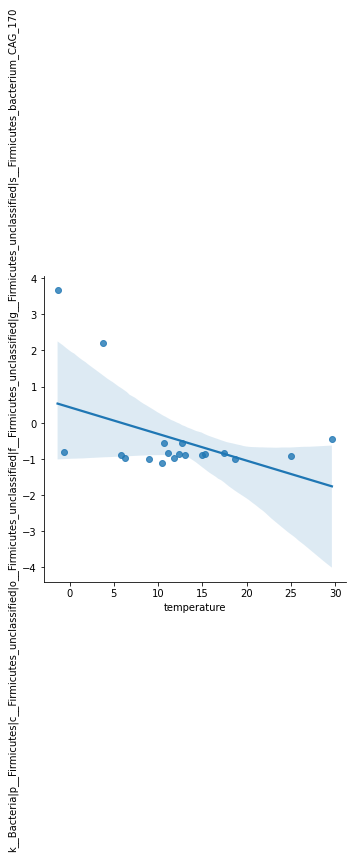

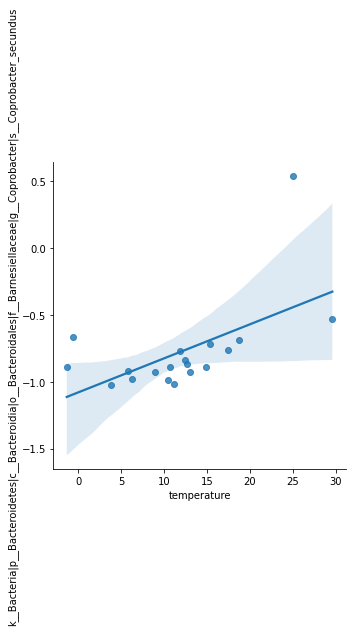

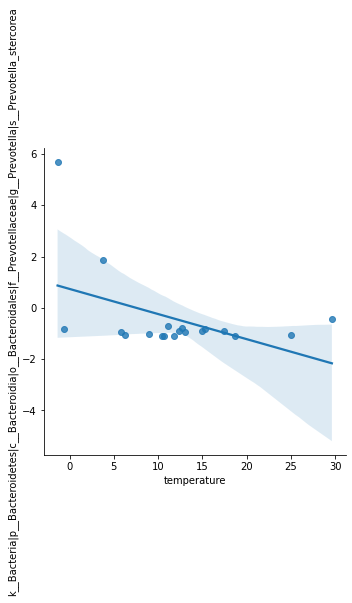

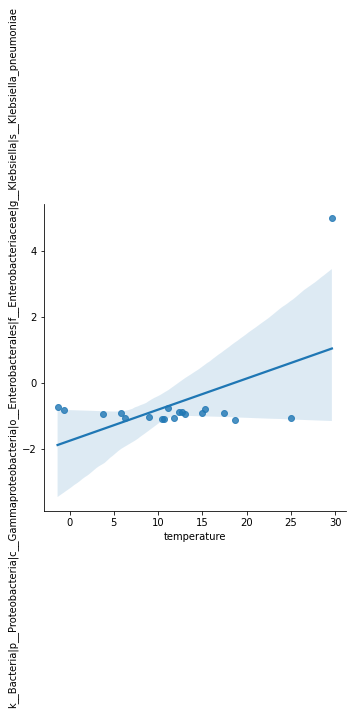

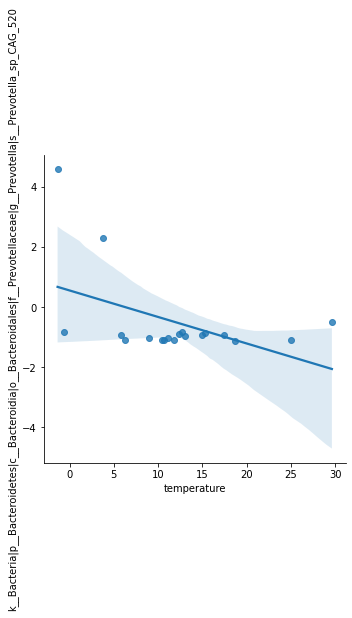

In [18]:
for species in clr_species:
    r, p = stats.pearsonr(dataframe_per_species['temperature'], dataframe_per_species[species])
    if abs(r) > 0.3 and p < 0.05:
        print(f"For {species}: {r} and p-value of {p}")
        sns.lmplot(x='temperature', y = species, data = dataframe_per_species)

In [19]:
genus_dict = {}
for species in dataframe_per_species.columns.drop('temperature'):
    genus = "|".join(species.split("|")[:-1])
    genus_dict[species] = genus
genus_df = dataframe_per_species.rename(genus_dict, axis = 1)
genus_df = genus_df.groupby(level=0, axis=1).sum()

In [20]:
final_df_clr_genus = pd.DataFrame()
counter = 0
for genus in genus_df.columns.drop('temperature'):
    final_df_clr_genus = pd.concat([final_df_clr_genus,pd.DataFrame(genus_df.groupby("temperature").median()[genus])], axis =1)
    counter += 1
    print(counter)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162


For k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Paraprevotella: 0.4613772963619718 and p-value of 0.04677010075149555
For k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_unclassified|g__Intestinimonas: -0.47776520595199556 and p-value of 0.03856303161611379
For k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruthenibacterium: -0.6077618252204062 and p-value of 0.005774024337663184


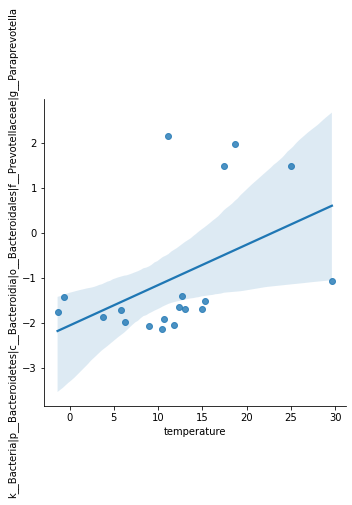

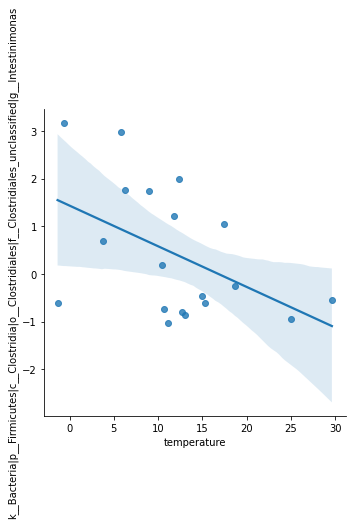

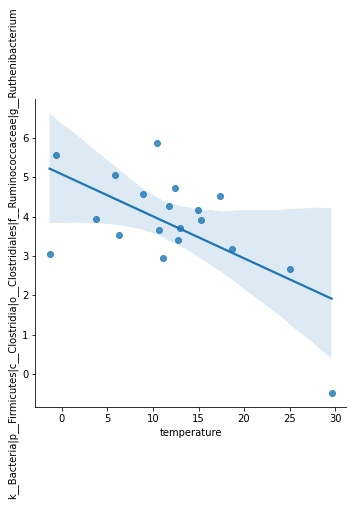

In [21]:
final_df_clr_genus = final_df_clr_genus.reset_index()
for genus in final_df_clr_genus.columns.drop('temperature'):
    r, p = stats.pearsonr(final_df_clr_genus["temperature"],final_df_clr_genus[genus])
    if p < 0.05 and abs(r) > 0.3:
        print(f"For {genus}: {r} and p-value of {p}")
        sns.lmplot(x="temperature", y = genus, data = final_df_clr_genus)

## Taking bottom 8 temps (from -1.35 to 10.7 = 1275 samples) and top 2 temps (25 and 29,6 = 1016 samples)

In [22]:
bottom_temps = dataframe_per_species[dataframe_per_species["temperature"] <= 10.7]

In [23]:
top_temps = dataframe_per_species[dataframe_per_species["temperature"] >= 25]

For species k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruthenibacterium|s__Ruthenibacterium_lactatiformans, difference is significant 0.044444444444444446
For species k__Bacteria|p__Firmicutes|c__Firmicutes_unclassified|o__Firmicutes_unclassified|f__Firmicutes_unclassified|g__Firmicutes_unclassified|s__Firmicutes_bacterium_CAG_83, difference is significant 0.044444444444444446
For species k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_salyersiae, difference is significant 0.044444444444444446
For species k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_CAG_144, difference is significant 0.044444444444444446
For species k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_finegoldii, difference is significant 0.044444444444444446
For species k__Bacteria|p__Bacteroidetes|c__

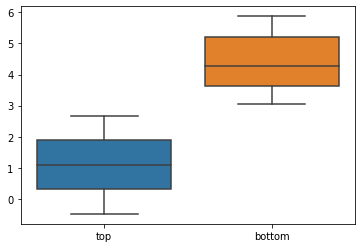

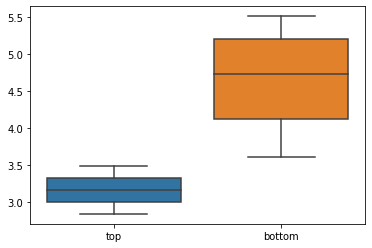

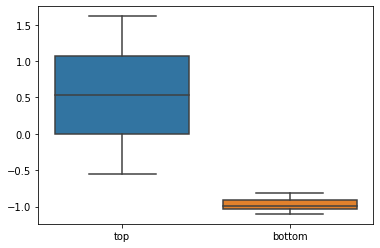

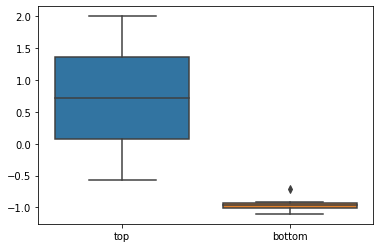

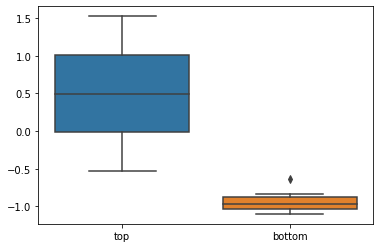

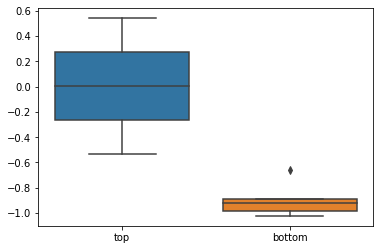

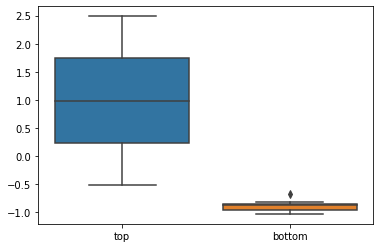

In [24]:
for species in clr_species:
    top_temps_list = np.array(top_temps[species])
    bottom_temps_list = np.array(bottom_temps[species])
    plot_df = pd.DataFrame([top_temps[species], bottom_temps[species]], index = ["top", "bottom"])
    p_value = stats.mannwhitneyu(top_temps_list, bottom_temps_list).pvalue
    if p_value < 0.05:
        print(f"For species {species}, difference is significant {p_value}")
        plt.figure(species)
        sns.boxplot(data=plot_df.T)

In [25]:
bottom_temps_genus = final_df_clr_genus[final_df_clr_genus["temperature"] <= 10.7]

In [26]:
top_temps_genus = final_df_clr_genus[final_df_clr_genus["temperature"] >= 25]

For genus k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Paraprevotella, difference is significant 0.044444444444444446
For genus k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruthenibacterium, difference is significant 0.044444444444444446


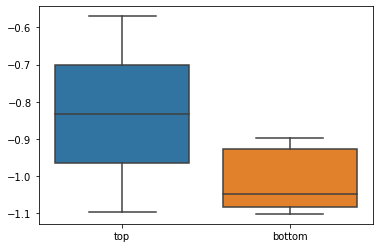

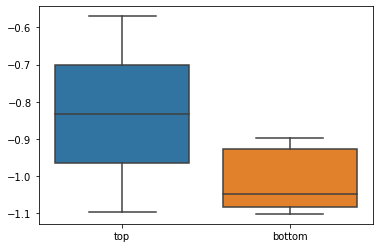

In [27]:
for genus in top_temps_genus.columns.drop('temperature'):
    top_temps_list = np.array(top_temps_genus[genus])
    bottom_temps_list = np.array(bottom_temps_genus[genus])
    p_value = stats.mannwhitneyu(top_temps_list, bottom_temps_list).pvalue
    if p_value < 0.05:
        print(f"For genus {genus}, difference is significant {p_value}")
        plt.figure(genus)
        sns.boxplot(data=plot_df.T)